https://realpython.com/python-keras-text-classification/

In [54]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [55]:
filepath_dict={'yelp':"data/sentiment_analysis/yelp_labelled.txt",
              'amazon':"data/sentiment_analysis/amazon_cells_labelled.txt",
              "imdb":"data/sentiment_analysis/imdb_labelled.txt"}

In [56]:
filepath_dict

{'yelp': 'data/sentiment_analysis/yelp_labelled.txt',
 'amazon': 'data/sentiment_analysis/amazon_cells_labelled.txt',
 'imdb': 'data/sentiment_analysis/imdb_labelled.txt'}

In [57]:
df_list=[]

for source, filepath in filepath_dict.items():
    #Name=sequence of Hashable, optional Sequence of column labels to apply. If the file contains a header row,
    #then you should explicitly pass ``header=0`` to override the column names.
    
    df=pd.read_csv(filepath,names=['sentence', 'label'],sep="\t")
    df['source']=source ## Add another column filled with the source name, this will serve as unique column to identify the related database
    df_list.append(df)
    

df=pd.concat(df_list) #Concatenate pandas objects along a particular axis.


In [58]:

df_list[0:3]

[                                              sentence  label source
 0                             Wow... Loved this place.      1   yelp
 1                                   Crust is not good.      0   yelp
 2            Not tasty and the texture was just nasty.      0   yelp
 3    Stopped by during the late May bank holiday of...      1   yelp
 4    The selection on the menu was great and so wer...      1   yelp
 ..                                                 ...    ...    ...
 995  I think food should have flavor and texture an...      0   yelp
 996                           Appetite instantly gone.      0   yelp
 997  Overall I was not impressed and would not go b...      0   yelp
 998  The whole experience was underwhelming, and I ...      0   yelp
 999  Then, as if I hadn't wasted enough of my life ...      0   yelp
 
 [1000 rows x 3 columns],
                                               sentence  label  source
 0    So there is no way for me to plug it in here i...      

In [59]:
df.iloc[0:11]

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp
5,Now I am getting angry and I want my damn pho.,0,yelp
6,Honeslty it didn't taste THAT fresh.),0,yelp
7,The potatoes were like rubber and you could te...,0,yelp
8,The fries were great too.,1,yelp
9,A great touch.,1,yelp


In [60]:
df.iloc[354:360]

,sentence,label,source
354,It was delicious!!!,1,yelp
355,"On the good side, the staff was genuinely plea...",1,yelp
356,"Sadly, Gordon Ramsey's Steak is a place we sha...",0,yelp
357,As always the evening was wonderful and the fo...,1,yelp
358,Best fish I've ever had in my life!,1,yelp
359,The bathroom is just next door and very nice.,1,yelp


The resulting vector is also called a feature vector. In a feature vector, each dimension can be a numeric or categorical feature, like for example the height of a building, the price of a stock, or, in our case, the count of a word in a vocabulary.
Let’s quickly illustrate this. Imagine you have the following two sentences:

In [61]:
sentences = ['John likes ice cream', 'John hates chocolate.']

In [62]:
from sklearn.feature_extraction.text import CountVectorizer
#(we used it in our Recommender System)


vectorizer=CountVectorizer(min_df=0.0,lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_


{'John': 0, 'likes': 5, 'ice': 4, 'cream': 2, 'hates': 3, 'chocolate': 1}

This vocabulary serves also as an index of each word. Now, you can take each sentence and get the word occurrences of the words based on the previous vocabulary. The vocabulary consists of all five words in our sentences, each representing one word in the vocabulary.When you take the previous two sentences and transform them with the CountVectorizer you will get a vector representing the count of each word of the sentence:

In [63]:
vectorizer.transform(sentences).toarray()


array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]], dtype=int64)

This is considered a Bag-of-words (BOW) model, which is a common way in NLP to create vectors out of text.Each document is represented as a vector. You can use these vectors now as feature vectors for a machine learning model. This leads us to our next part, defining a baseline model.

## Defining a Baseline Model:

When you work with machine learning, one important step is to define a baseline model. This usually involves a simple model, which is then used as a comparison with the more advanced models that you want to test. In this case, you’ll use the baseline model to compare it to the more advanced methods involving (deep) neural networks, the meat and potatoes of this tutorial.

We start by taking the Yelp data set which we extract from our concatenated data set. From there, we take the sentences and labels. The .values returns a NumPy array instead of a Pandas Series object which is in this context easier to work with:

In [64]:
from sklearn.model_selection import train_test_split 

df_yelp=df[df['source']=='yelp']
sentences=df_yelp['sentence'].values # change the values into arrays  
y=df_yelp['label'].values

In [65]:
sentences[0:5],y[0:5]

(array(['Wow... Loved this place.', 'Crust is not good.',
        'Not tasty and the texture was just nasty.',
        'Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.',
        'The selection on the menu was great and so were the prices.'],
       dtype=object),
 array([1, 0, 0, 1, 1], dtype=int64))

In [66]:
sentences_train, sentences_test, y_train, y_test=train_test_split(sentences,y,test_size=0.25,random_state=1000)

Here we will use again on the previous BOW model to vectorize the sentences. You can use again the CountVectorizer for this task. Since you might not have the testing data available during training, you can create the vocabulary using only the training data. Using this vocabulary, you can create the feature vectors for each sentence of the training and testing set:

In [67]:
vectorizer.fit(sentences_train) #Learn a vocabulary dictionary of all tokens (numerical matrix of word or token counts) in the raw documents

 
#teansformer:Transform documents to document-term matrix. Extract token counts out of raw text documents using the vocabulary
#fitted with fit or the one provided to the constructor.
    
X_train=vectorizer.transform(sentences_train)
X_test=vectorizer.transform(sentences_test)
X_train

<750x1938 sparse matrix of type '<class 'numpy.int64'>'
	with 7453 stored elements in Compressed Sparse Row format>

You can see that the resulting feature vectors have 750 samples which are the number of training samples we have after the train-test split. Each sample has 2505 dimensions which is the size of the vocabulary. Also, you can see that we get a sparse matrix. This is a data type that is optimized for matrices with only a few non-zero elements, which only keeps track of the non-zero elements reducing the memory load

CountVectorizer performs tokenization which separates the sentences into a set of tokens as you saw previously in the vocabulary. It additionally removes punctuation and special characters and can apply other preprocessing to each word. If you want, you can use a custom tokenizer from the NLTK library with the CountVectorizer or use any number of the customizations which you can explore to improve the performance of your model. The classification model we are going to use is the logistic regression which is a simple yet powerful linear mode

In [68]:
from sklearn.linear_model import LogisticRegression 

classifier=LogisticRegression()

In [69]:
classifier.fit(X_train,y_train)
score=classifier.score(X_test,y_test)

print("Accuracy score:",score)

Accuracy score: 0.772


In [70]:
#let’s have a look how this model performs on the other data sets that we have

for source in df["source"].unique():
    df_source=df[df["source"]==source]
    sentences=df_source["sentence"].values
    y=df_source["label"].values 
    sentence_train, sentence_test,y_train, y_test=train_test_split(sentences, y, test_size=0.25,random_state=1000)
    vectorizer=CountVectorizer()
    vectorizer.fit(sentence_train)
    X_train=vectorizer.transform(sentence_train)
    X_test=vectorizer.transform(sentence_test)
    
    classifier=LogisticRegression()
    classifier.fit(X_train,y_train)
    score=classifier.score(X_test,y_test)
    print("Accuracy for {} data: {:.4f}".format(source,score))
    
    
    

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


# Doing the same thing with Deep Neural Network

In [71]:
from keras.models import Sequential 

In [72]:
from keras import layers

In [73]:
X_train.shape,X_train.shape[0],X_train.shape[1],X_test.shape,y_test.shape,sentence_train.shape,sentence_test.shape


((561, 2505), 561, 2505, (187, 2505), (187,), (561,), (187,))

In [74]:
input_shape=X_train.shape
input_dim=X_train.shape[1] #features (columns)
from keras.layers import Dense, Conv2D , Conv3D, MaxPool2D , Flatten , Dropout 

model=Sequential()
#model.add(layers.Dense(input_shape,activation='relu')) #this didn't work, the summary was not showing params and output shape

model.add(layers.Dense(10,input_dim=X_train.shape[1],activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.02))) #10 nodes
#, kernel_regularizer=tf.keras.regularizers.l2(0.01),
model.add(Dense(32,activation="relu"))

model.add(layers.Dense(1,activation='sigmoid'))

d:\ai local\practice_projects\env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [75]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [76]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │          25,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,445 (99.39 KB)

 Trainable params: 25,445 (99.39 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
#Make sure to call clear_session() before you start training the model again:
from keras.backend import clear_session
clear_session()
#tf.compat.v1.reset_default_graph


In [78]:
#I WAS STUCKED FOR HOURS AT THIS STAGE, THERE WAS AN ERROR OF DATA TYPE ERROR, WHICH WAS RESOLVE ONCE I UPDATED THE KERAS TO LATEST version

history=model.fit(X_train,y_train,epochs=30,verbose=False,validation_data=(X_test,y_test),batch_size=10)

In [79]:
#pip list
#pip install keras==2.15
#pip install tensorflow==2.15, THIS WAS NOT INSTALLED AS PYTHON 3.10 DOESN'T SUPPORT TENSORFLOW 2.15
#from platform import python_version

#print(python_version())

#pip install keras --upgrade


In [80]:
X_train.shape,y_train.shape

((561, 2505), (561,))

In [81]:


loss, accuracy=model.evaluate(X_train,y_train,verbose=True)
loss, accuracy=model.evaluate(X_test,y_test,verbose=True)

print(history.history.keys()),loss,accuracy

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9512 - loss: 0.5467
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7308 - loss: 0.8467 
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


(None, 0.9182839393615723, 0.7165775299072266)

why loss is increasing: (loss is now decreased due to application of L1 reg. term)


https://stackoverflow.com/questions/40910857/how-to-interpret-increase-in-both-loss-and-accuracy

L1 and L2 Regularization in Neural Networks:
https://spotintelligence.com/2023/05/26/l1-l2-regularization/#:~:text=L1%20regularization%20adds%20the%20sum,smaller%20but%20non%2Dzero%20coefficients.

how to appply L1 and L2:
https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-keras.md



In [82]:

import matplotlib.pyplot as plt
plt.style.use('ggplot')
def plot_history(history):
    acc=history.history["accuracy"]
    val_acc=history.history["val_accuracy"]
    loss=history.history["loss"]
    val_loss=history.history["val_loss"]
    x=range(1,len(acc)+1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(x,acc,'b',label='Training Acc')
    plt.plot(x,val_acc,'r',label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(x,loss,'b',label="Training Loss")
    plt.plot(x,val_loss,"r",label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.legend()



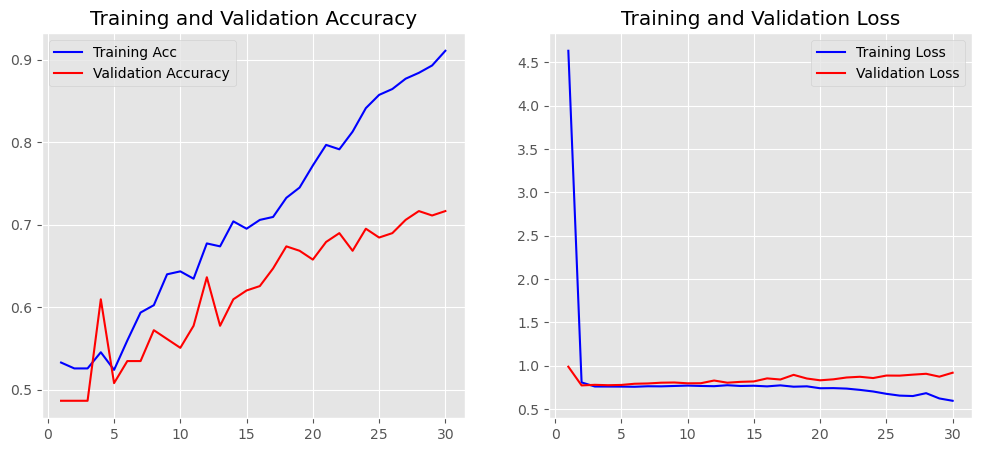

In [83]:
plot_history(history)

You can see that we have trained our model for too long since the training set reached 100% accuracy. A good way to see when the model starts overfitting is when the loss of the validation data starts rising again. This tends to be a good point to stop the model. You can see this around 20-40 epochs in this training.

# Using Word Embeddings

In [84]:
sentence_train[0:3],X_train[0:3]
X_train.shape,y_train.shape,sentence_train.shape,sentence_test.shape

((561, 2505), (561,), (561,), (187,))

In [85]:

#the preprocessing.text was depricated, the one which was given in tutorial, so i had skipped this section,
#however next day I used tf and keras documentation and some articles to find my way 

#https://community.deeplearning.ai/t/recommended-way-to-tokenize-new-code/517807
#https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

#https://medium.com/@hsinhungw/understanding-word-embeddings-with-keras-dfafde0d15a4#:~:text=The%20Embedding%20Layer%20in%20Keras%20is%20designed%20to%20map%20positive,Layer%20to%20preprocess%20the%20text.


#max_tokens=max vocab size
max_len =50

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens = 5000,
    standardize = 'lower_and_strip_punctuation',
    output_sequence_length = max_len #i think it is already doing the job of padding which i have done in my next code
)

vectorize_layer.adapt(sentences) #create the vocabulary.

vectorize_layer.get_vocabulary()

# Now, the layer can map strings to integers -- you can use an
# embedding layer to map these integers to learned embeddings.

#sentences_to_tokens = vectorize_layer()
X_train=vectorize_layer(sentence_train)
X_test=vectorize_layer(sentence_test)


In [86]:
X_train.shape,y_train.shape,sentences_train.shape,sentence_train[4],X_train[4]

(TensorShape([561, 50]),
 (561,),
 (750,),
 'Not frightening in the least, and barely comprehensible.  ',
 <tf.Tensor: shape=(50,), dtype=int64, numpy=
 array([  27,  650,   11,    2,  212,    4,  504, 2817,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0], dtype=int64)>)


One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use pad_sequence() which simply pads the sequence of words with zeros. By default, it prepends zeros but we want to append them. Typically it does not matter whether you prepend or append zeros.

Additionally you would want to add a maxlen parameter to specify how long the sequences should be. This cuts sequences that exceed that number. 
https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences

In [87]:

from keras.utils import pad_sequences

#### Additional Note:

import tensorflow as tf 
means you are importing tensorflow with an alias as tf to call it modules/functions.

You cannot use the alias to import other modules.

For your case, if you call directly

tf.keras.preprocessing.image.ImageDataGenerator(...) 
then it will work.

or

you need to import the module with the right module name. i.e.

from tensorflow.keras.preprocessing.image import ImageDataGenerat

In [88]:
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences

X_train = pad_sequences(X_train, padding='post', maxlen=max_len) #padding make the arrays of the same size by padding them with the value (here 0
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)


In [89]:
X_train.shape,y_train.shape,sentence_train[4],X_train[4]

((561, 50),
 (561,),
 'Not frightening in the least, and barely comprehensible.  ',
 array([  27,  650,   11,    2,  212,    4,  504, 2817,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]))

# Keras Embedding Layer

https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce

Notice that, at this point, our data is still hardcoded. We have not told Keras to learn a new embedding space through successive tasks. Now you can use the Embedding Layer of Keras which takes the previously calculated integers and maps them to a dense vector of the embedding. You will need the following parameters:

input_dim: the size of the vocabulary
output_dim: the size of the dense vector
input_length: the length of the sequence
With the Embedding layer we have now a couple of options. One way would be to take the output of the embedding layer and plug it into a Dense layer. In order to do this you have to add a Flatten layer in between that prepares the sequential input for the Dense layer:

In [90]:
embedding_dim


50

In [91]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50
maxlen =100
vocab_size=vectorize_layer.vocabulary_size()
model = Sequential()

model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim)) #The output of the embedding layer is a 2D vector where every vector represents a single word from the vocabulary. 
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5309 - loss: 0.6927 - val_accuracy: 0.5241 - val_loss: 0.6912
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7120 - loss: 0.6600 - val_accuracy: 0.5829 - val_loss: 0.6848
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8815 - loss: 0.5677 - val_accuracy: 0.5989 - val_loss: 0.6642
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9344 - loss: 0.3195 - val_accuracy: 0.6471 - val_loss: 0.6380
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9902 - loss: 0.1151 - val_accuracy: 0.6791 - val_loss: 0.6242
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0457 - val_accuracy: 0.7005 - val_loss: 0.6372
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0200 - val_accuracy: 0.6631 - val_loss: 0.6599
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0150 - val_accuracy: 0.7059 - val_loss:

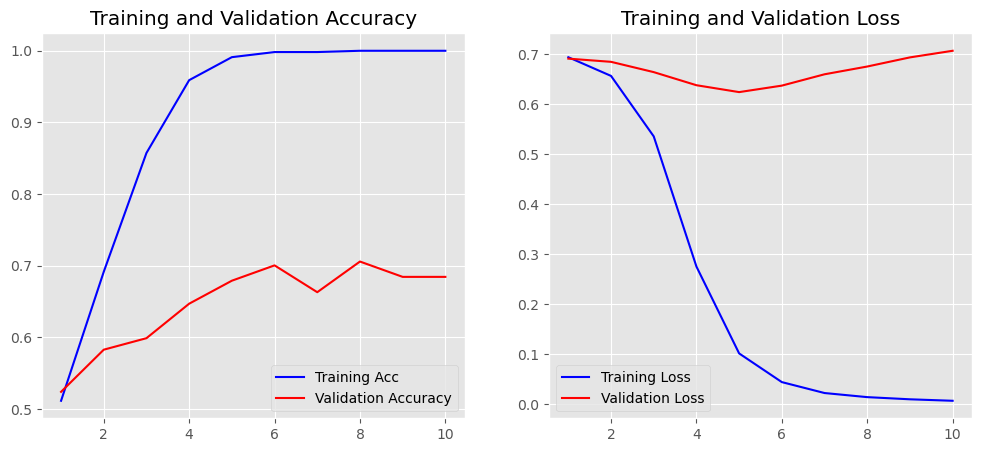

In [92]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)



loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

This is typically a not very reliable way to work with sequential data as you can see in the performance. When working with sequential data you want to focus on methods that look at local and sequential information instead of absolute positional information.

Another way to work with embeddings is by using a MaxPooling1D/AveragePooling1D or a GlobalMaxPooling1D/GlobalAveragePooling1D layer after the embedding. You can think of the pooling layers as a way to downsample (a way to reduce the size of) the incoming feature vectors.

Pooling is an operation as a layer offered by Keras to be implemented by adding to CNN between layers. The main purpose of pooling is to reduce the size of feature maps, which in turn makes computation faster because the number of training parameters is reduced. The pooling operation summarizes the features present in a region, the size of which is determined by the pooling filter


In the case of max pooling you take the maximum value of all features in the pool for each feature dimension. In the case of average pooling you take the average, but max pooling seems to be more commonly used as it highlights large values.

Max Pooling is a pooling operation that calculates the maximum value for patches of a feature map, and uses it to create a downsampled (pooled) feature map. It is usually used after a convolutional layer

.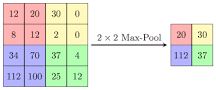!


Global max/average pooling takes the maximum/average of all features whereas in the other case you have to define the pool size. Keras has again its own layer that you can add in the sequential model:
Dense layers, also known as fully-connected layers, are fundamental building blocks of neural networks in Keras.


In [93]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# L1 and L2 Regularization 

https://neptune.ai/blog/fighting-overfitting-with-l1-or-l2-regularization
L1 regularization, also known as L1 norm or Lasso (in regression problems), combats overfitting by shrinking the parameters towards 0. This makes some features obsolete. 

It’s a form of feature selection, because when we assign a feature with a 0 weight, we’re multiplying the feature values by 0 which returns 0, eradicating the significance of that feature. If the input features of our model have weights closer to 0, our L1 norm would be sparse. A selection of the input features would have weights equal to zero, and the rest would be non-zero. 


L2 regularization, or the L2 norm, or Ridge (in regression problems), combats overfitting by forcing weights to be small, but not making them exactly 0. 


In [94]:

clear_session(free_memory=True)


history= model.fit(X_train,y_train, epochs=12,verbose=True, validation_data=(X_test,y_test),batch_size=5,)

Epoch 1/12
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4873 - loss: 0.8313 - val_accuracy: 0.6845 - val_loss: 0.7564
Epoch 2/12
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6801 - loss: 0.7376 - val_accuracy: 0.6578 - val_loss: 0.7109
Epoch 3/12
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8120 - loss: 0.6778 - val_accuracy: 0.6684 - val_loss: 0.6780
Epoch 4/12
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9073 - loss: 0.5935 - val_accuracy: 0.6631 - val_loss: 0.6499
Epoch 5/12
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9394 - loss: 0.4578 - val_accuracy: 0.7433 - val_loss: 0.6120
Epoch 6/12
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9549 - loss: 0.3281 - val_accuracy: 0.7433 - val_loss: 0.6074
Epoch 7/12
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9927 - loss: 0.2407 - val_accuracy: 0.7433 - val_loss: 0.6165
Epoch 8/12
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9944 - loss: 0.2078 - val_accuracy: 0.

In [95]:
loss, accuracy = model.evaluate(X_train,y_train,verbose=False)
print("Training Accuracy: {:.2f} %,Testing Accuracy: {:.2f} %".format(accuracy*100,loss *100) )

loss,accuracy=model.evaluate(X_test,y_test,verbose=False)
print("\nTesting Accuracy: {:.2f} %, Testing Error: {:.2f} %".format(accuracy*100,loss*100))


Training Accuracy: 99.82 %,Testing Accuracy: 10.90 %

Testing Accuracy: 77.54 %, Testing Error: 57.27 %


How Vectors in Machine Learning Supply AI Engines with Data

https://shelf.io/blog/vectors-in-machine-learning/#:~:text=In%20machine%20learning%20models%2C%20vectors,or%20attribute%20of%20the%20data.


Vector Embeddings Explained

https://weaviate.io/blog/vector-embeddings-explained


# Using Pretrained Word Embeddings

In [96]:
import numpy as np


#https://www.kaggle.com/code/thierryneusius/textvectorization-embedding-layer-with-keras

def create_embeding_matrix(glove_file,vocabulary,verbose=False):
    embeddings_index={}
    
    with open (glove_file,encoding="utf8") as f:
        for line in f:
            values=line.split()
            word=values[0]
            coefs=np.asarray(values[1:],dtype='float32')
            embeddings_index[word]=coefs

    any_word=list(embeddings_index.keys())[10]
    emb_dim=embeddings_index[any_word].shape[0]
    
    word_index=dict(zip(vocabulary,range(len(vocabulary)))) #The zip() function in Python is used to combine two or more iterable dictionaries into a single
                                                            #iterable, where corresponding elements from the input iterable are paired together as tuples.

    if verbose:
        print("Found {} word vectors".format(len(embeddings_index)))
        print("Embedding dimensions: ",emb_dim)

    num_tokens=len(vocabulary)+1
    embedding_matrix=np.zeros(shape=(num_tokens,emb_dim))
    
    if verbose:
        print("Embedding Matrix dimmesion:",embedding_matrix.shape)
            

    # In the vocabulary, index 0 is reserved for padding
    # and index 1 is reserved for "out of vocabulary" tokens.
    # The first 2 word in the vocabulary are '', '[UNK]'

    hits=0
    misses=0

    for word, i in word_index.items():
        embedding_vector=embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i]=embedding_vector
            hits+=1
        else:
            misses+=1
            
    if verbose:
           print("Converted {} words ({} misses)".format(hits, misses))
    return embedding_matrix


    
    
        
#tokenization — Splitting text into smaller units such as words or phrases. 
#vectorization — Converting text into numerical representations/ interger sequence for ML models                              
    

In [97]:
embedding_dim=50
embedding_matrix=create_embeding_matrix('data/glove.6B/glove.6B.50d.txt',vectorize_layer.get_vocabulary(),verbose=True)

Found 400000 word vectors
Embedding dimensions:  50
Embedding Matrix dimmesion: (3178, 50)
Converted 2997 words (180 misses)


In [102]:
model=Sequential()
model.add(layers.Embedding(vocab_size+1,embedding_dim,weights=[embedding_matrix],input_length=maxlen,trainable=False))
model.add(layers.GlobalAvgPool1D())
model.add(layers.Dense(10,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │         158,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 158,900 (620.70 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 158,900 (620.70 KB)

Training Accuracy: 0.7897
Testing Accuracy:  0.7540


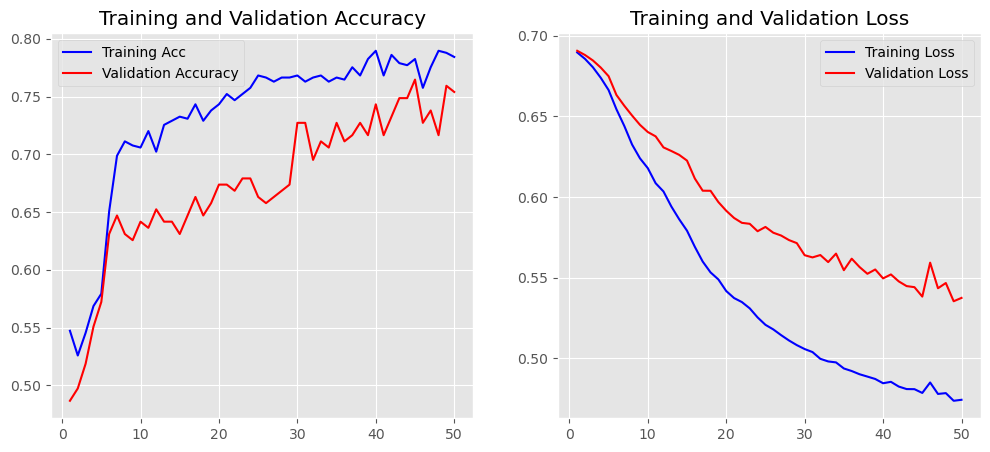

### let’s now see how this performs if we allow the embedding to be trained by using trainable=True:


In [109]:
model=Sequential()
model.add(layers.Embedding(vocab_size+1,embedding_dim,weights=[embedding_matrix],input_length=maxlen,trainable=True))
model.add(layers.GlobalAvgPool1D())
model.add(layers.Dense(10,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │         158,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_6           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 158,900 (620.70 KB)

 Trainable params: 158,900 (620.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/26
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9981 - loss: 0.0162 - val_accuracy: 0.7968 - val_loss: 0.6156
Epoch 2/26
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0129 - val_accuracy: 0.7219 - val_loss: 0.7284
Epoch 3/26
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 0.7914 - val_loss: 0.6343
Epoch 4/26
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9989 - loss: 0.0126 - val_accuracy: 0.6898 - val_loss: 1.0149
Epoch 5/26
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9872 - loss: 0.0277 - val_accuracy: 0.8021 - val_loss: 0.6315
Epoch 6/26
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9946 - loss: 0.0106 - val_accuracy: 0.8075 - val_loss: 0.6379
Epoch 7/26
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0076 - val_accuracy: 0.7701 - val_loss: 0.6879
Epoch 8/26
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9870 - loss: 0.0223 - val_accuracy: 0.7914 - val_loss:

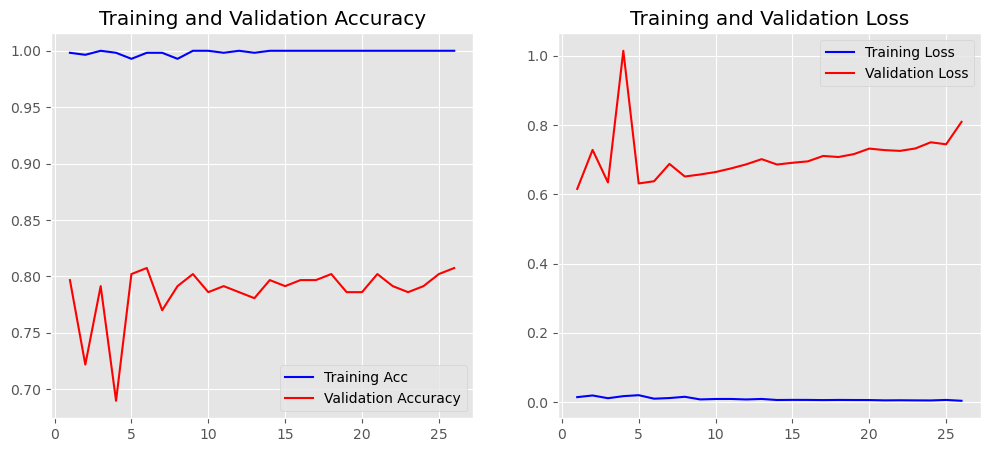

In [113]:
history = model.fit(X_train, y_train,
                    epochs=26,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Now it is time to focus on a more advanced neural network model to see if it is possible to boost the model and give it the leading edge over the previous models.

# Convolutional Neural Networks (CNN)


https://medium.com/@learnwithwhiteboard_digest/difference-between-ann-vs-cnn-vs-rnn-ae40269b46e7#:~:text=The%20key%20difference%20between%20a,using%20a%20set%20of%20weights.


Convolution is a mathematical operation that allows the merging of two sets of information. In the case of CNN, convolution is applied to the input data to filter the information and produce a feature map.

The key difference between a CNN and other types of neural networks is that it uses a process called “convolution” to extract features from the input data.

In a convolutional layer, the input data is divided into small “kernels,” or squares, which are then processed using a set of weights. These weights are adjusted during the training process to identify patterns and features in the input data. The output of the convolutional layer is a set of “feature maps,” which represent the presence of different features in the input data

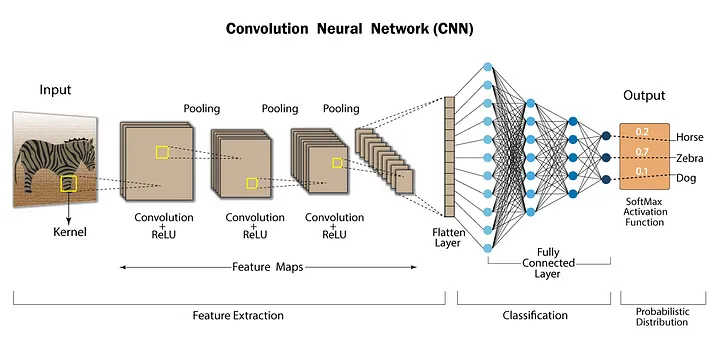






In [115]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()



Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training Accuracy: 1.0000
Testing Accuracy:  0.7540


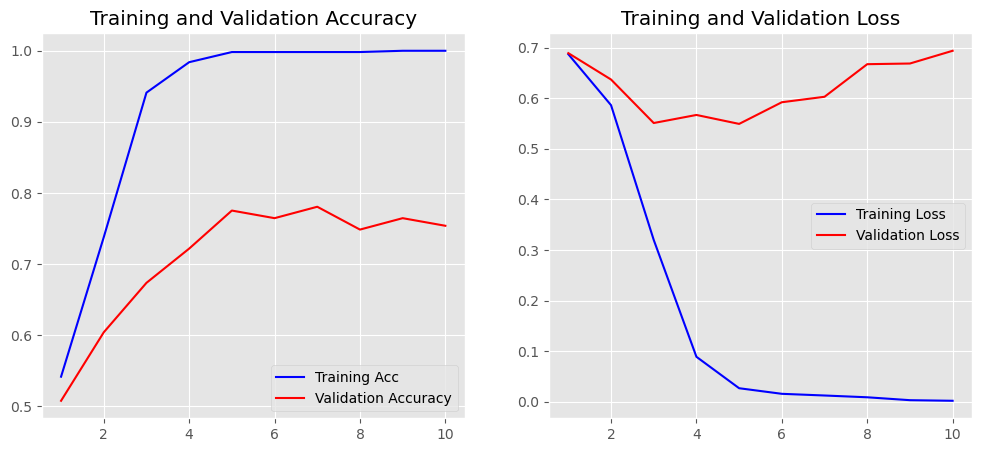

In [116]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

You can see that 80% accuracy seems to be tough hurdle to overcome with this data set and a CNN might not be well equipped. The reason for such a plateau might be that:

- There are not enough training samples
- The data you have does not generalize well
- Missing focus on tweaking the hyperparameters

CNNs work best with large training sets where they are able to find generalizations where a simple model like logistic regression won’t be able.

# Hyperparameters Optimization

When you have a look at the competitions on Kaggle, one of the largest places to compete against other fellow data scientists, you can see that many of the winning teams and models have gone through a lot of tweaking and experimenting until they reached their prime. So don’t get discouraged when it gets tough and you reach a plateau, but rather think about the ways you could optimize the model or the data.

One popular method for hyperparameter optimization is grid search. What this method does is it takes lists of parameters and it runs the model with each parameter combination that it can find. It is the most thorough way but also the most computationally heavy way to do this. Another common way, random search, which you’ll see in action here, simply takes random combinations of parameters.

In order to apply random search with Keras, you will need to use the KerasClassifier which serves as a wrapper for the scikit-learn API. With this wrapper you are able to use the various tools available with scikit-learn like cross-validation. The class that you need is RandomizedSearchCV which implements random search with cross-validation. Cross-validation is a way to validate the model and take the whole data set and separate it into multiple testing and training data set

First step for KerasClassifier is to have a function that creates a Keras model. We will use the previous model, but we will allow various parameters to be set for the hyperparameter optimization:

s.

In [118]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    

Next, you want to define the parameter grid that you want to use in training. This consists of a dictionary with each parameters named as in the previous function. The number of spaces on the grid is 3 * 3 * 1 * 1 * 1, where each of those numbers is the number of different choices for a given parameter.

In [126]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

#i stopped here as the code i copied was generating errors.
#the code is copied just for idea as this may be implemented in professional projects in future

from keras.layers.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    prompt = input(f'finished {source}; write to file and proceed? [y/n]')
    if prompt.lower() not in {'y', 'true', 'yes'}:
        break
    with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)